In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

conn = sqlite3.connect("../db/baltasar.db")
def sql(query):
    return pd.read_sql_query(query, conn)

## Iteration 1

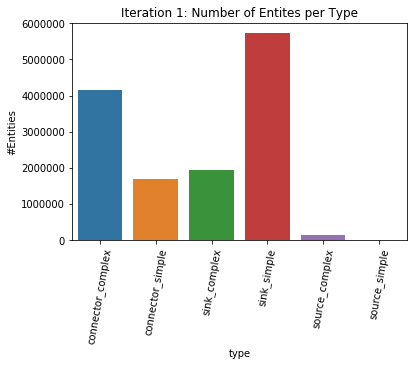

In [9]:
graphProperties = sql('''
SELECT "sink_simple" as type, count(*) as "#Entities" FROM EntityMetadata WHERE indegree = 1 and outdegree = 0
UNION
SELECT "sink_complex", count(*) FROM EntityMetadata WHERE indegree > 1 and outdegree = 0
UNION
SELECT "source_simple", count(*) FROM EntityMetadata WHERE indegree = 0 and outdegree = 1
UNION
SELECT "source_complex", count(*) FROM EntityMetadata WHERE indegree = 0 and outdegree > 1
UNION
SELECT "connector_simple", count(*) FROM EntityMetadata 
WHERE 
    indegree = 1 and outdegree = 1
UNION
SELECT "connector_complex", count(*) FROM EntityMetadata 
WHERE 
    indegree > 0 and outdegree > 0
''')
ax = sns.barplot(data=graphProperties, x='type', y='#Entities')
ax.set_title('Iteration 1: Number of Entites per Type')
plt.xticks(rotation=80)
plt.savefig('graphs/iter1.pdf')
plt.show()

In [11]:
graphProperties

,type,#Entities
0,connector_complex,4160266
1,connector_simple,1681459
2,sink_complex,1943297
3,sink_simple,5726386
4,source_complex,158433
5,source_simple,13005


## Iteration 2

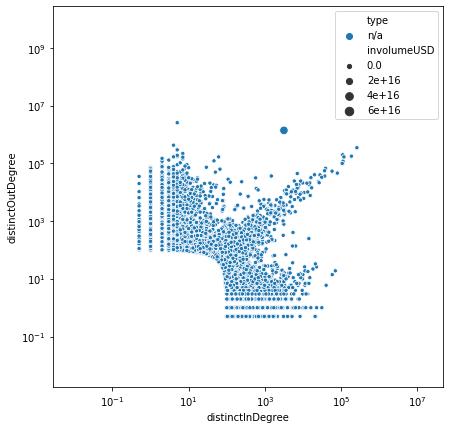

In [17]:
df = sql('SELECT * FROM EntityMetadata WHERE distinctDegree >= 100')

df['type'] = "n/a"
df.loc[df['distinctInDegree'] == 0, ['distinctInDegree']] = 0.5
df.loc[df['distinctOutDegree'] == 0, 'distinctOutDegree'] = 0.5

#df.loc[df['isDiluter'] == 1, ['type']] = 'diluter'
#df.loc[df['isMixer'] == 1, ['type']] = 'mixer'
#df.loc[df['isConcentrator'] == 1, ['type']] = 'concentrator'

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='distinctInDegree', y='distinctOutDegree', hue="type", size="involumeUSD", data=df, ax=ax)

(0.1, 10000000)

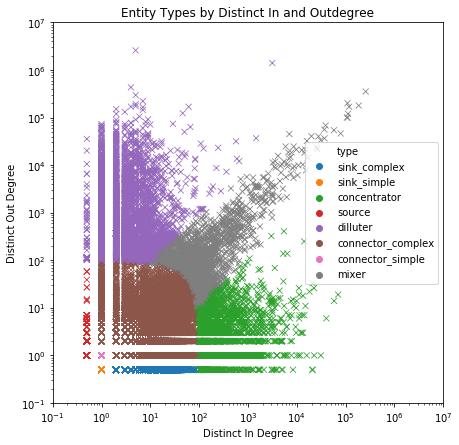

In [64]:
df = sql('''
SELECT m.distinctInDegree, m.distinctOutDegree, type, isExchange
FROM
    EntityMetadata m
    NATURAL JOIN
    EntityTaxonomy t
    NATURAL JOIN
    Entity e
WHERE m.distinctDegree > 100 or m.name LIKE "%F" 
''')
df.loc[df['distinctInDegree'] == 0, ['distinctInDegree']] = 0.5
df.loc[df['distinctOutDegree'] == 0, 'distinctOutDegree'] = 0.5

#df.loc[df['isExchange'] == 1, 'type'] = "exchange"
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(x='distinctInDegree', y='distinctOutDegree', hue="type", marker='x', data=df, ax=ax)
plt.title('Entity Types by Distinct In and Outdegree')
plt.xlabel('Distinct In Degree')
plt.ylabel('Distinct Out Degree')
ax.set_xlim([10**-1,10**7])
ax.set_ylim([10**-1,10**7])


# Iteration 3

ICOs, Capps and Exchanges were found before. We analyze them empirically to determine if they fit into the type dimension or should get other Dimensions. Thus, we chose empirical to conceptual.

In [25]:
sql('''
SELECT type, count(distinct Entity.name),sum(Entity.isExchange) FROM 
    (ICOAddress 
    NATURAL JOIN 
    Address)
    INNER JOIN
    (Entity
    NATURAL JOIN
    EntityTaxonomy)
    ON Entity.name = Address.cluster
GROUP BY type''')

,type,count(distinct Entity.name),sum(Entity.isExchange)
0,connector_complex,302,0
1,dilluter,2226,1
2,mixer,46,13


ICOs are in most cases dilluters, which makes sense as they sell tokens to a large audience. The included Mixers appear to be Initial Exchange Offerings, in which an exchange sells the token instead of a smart contract. The high number of connectors is surprising.

In [27]:
sql('''
SELECT type, count(distinct Entity.name), sum(Entity.isExchange)
FROM
    Address
    INNER JOIN
    (Entity
    NATURAL JOIN
    EntityTaxonomy)
    ON Address.cluster = Entity.name
WHERE Address.isCappReceiver = 1
GROUP BY type
''')

,type,count(distinct Entity.name),sum(Entity.isExchange)
0,concentrator,52,0
1,connector_complex,431,0
2,dilluter,11,0
3,mixer,415,180


Capps are most often mixers or complex connectors, dilluters and concentrators also exist.

In [21]:
sql('''
SELECT type, count(*)
FROM
    Entity
    NATURAL JOIN
    EntityTaxonomy
WHERE Entity.isExchange = 1
GROUP BY type''')

,type,count(*)
0,concentrator,1
1,connector_complex,9
2,dilluter,2
3,mixer,43
4,sink_complex,8
5,sink_simple,1


Exchanges were labelled by users of Etherscan. The sinks and connectors are Exchanges which do not trade tokens included in the dataset, but for example Ether for Bitcoin. Exchanges are most often mixers.

Conceptually, an ICO and an Exchange represent a type of entity which is fundamentally different from other addresses. An ICO or Exchange will interact with other entities similarly: In the case of an ICO, it will emit tokens to many addresses and in the case of the exchange, it will receive and send tokens from many different addresses. Therefore the two are included in the type dimension. However, it is important to note that in the labels only ICOs and Exchange that could definitely marked are included. It is very likely that dilluters and mixers include more entities which also are exchanges and ICOs respectively.

Initial Exchange Offerings are somewhat difficult to classify because they are exchanges and ICOs (by the definition in chapter \todo{}) at the same time. As they are foremost exchanges and only rarely perform ICOs, they are marked as exchanges.

Centralized Applications are defined by their use of deposit addresses. As shown in table \todo{}, they are often exchanges and often mixers. However, conceptually, a centralized application can also be used to collect funds and provide a service which would most likely form a Concentrator-like pattern. Therefore, the fact that an entity is a Capp is independent of it's type.

# Iteration 4

Conceptual: An entity can be
- empty
- active
- dormant

In [33]:
sql('''
SELECT 
    involumeUSD - outvolumeUSD BETWEEN -0.05 and 0.05 as empty, count(*)
FROM EntityMetadata
WHERE name LIKE "%F"
GROUP BY empty
''')

,empty,count(*)
0,0,443920
1,1,304293


In [16]:
df = sql('''
SELECT 
    b.block, timestamp, lastActivity, lastReceive, lastSent
FROM
    (SELECT lastActiveOn / 60000 * 60000 as block, count(*) as lastActivity
        FROM
        (SELECT name, MAX(IFNULL(lastInTransfer,0), IFNULL(lastOutTransfer,0)) as lastActiveOn FROM 
            (SELECT * FROM EntityMetadata where name LIKE "%FF") m
        WHERE
            not involumeUSD - outvolumeUSD BETWEEN -0.05 and 0.05)
    GROUP BY block) b
    NATURAL JOIN
    (SELECT lastActiveOn / 60000 * 60000 as block, count(*) as lastReceive
        FROM
        (SELECT name, lastInTransfer as lastActiveOn FROM 
            (SELECT * FROM EntityMetadata where name LIKE "%FF") m
        WHERE
            not involumeUSD - outvolumeUSD BETWEEN -0.05 and 0.05
            and lastInTransfer is not null)
    GROUP BY block) r
    NATURAL JOIN
    (SELECT lastActiveOn / 60000 * 60000 as block, count(*) as lastSent
        FROM
        (SELECT name, lastOutTransfer as lastActiveOn FROM 
            (SELECT * FROM EntityMetadata where name LIKE "%FF") m
        WHERE
            not involumeUSD - outvolumeUSD BETWEEN -0.05 and 0.05
            and lastOutTransfer is not null)
    GROUP BY block) s
    LEFT OUTER JOIN
    (SELECT blocknumber, 1.0*timestamp as timestamp from 
    ETransfer
    GROUP BY blocknumber)
    ON blocknumber = s.block
''')
df

,block,timestamp,lastActivity,lastReceive,lastSent
0,2340000,NaN,1,1,1
1,3420000,NaN,3,2,3
2,3600000,NaN,17,15,3
3,3660000,NaN,6,6,2
4,3720000,NaN,9,9,2
5,3780000,1.491884e+09,22,24,2
6,3840000,1.490804e+09,20,19,3
7,3900000,NaN,26,29,7
8,3960000,NaN,16,14,7
9,4020000,1.487012e+09,14,12,11


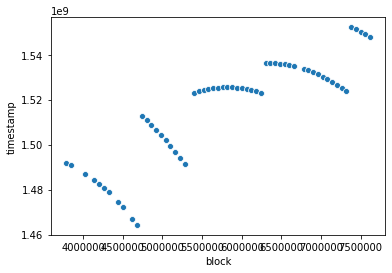

In [35]:
df_inter = df.interpolate(method ='linear', limit_direction ='both', limit=10000) 
#df_grouped = pd.melt(df_inter, id_vars=['block', 'timestamp'], value_vars=['lastActivity', 'lastSent', 'lastReceive'])

#df_grouped
#sns.scatterplot(data = df_grouped, x="block", y="value", hue='variable')
sns.scatterplot(data = df, x='block', y='timestamp')
#df_inter[df_inter['timestamp'].isnull()]

In [38]:
sql('''
CREATE TABLE blockTimestamps AS
SELECT blocknumber, timestamp from 
ETransfer
GROUP BY blocknumber''')

KeyboardInterrupt: 

## Iteration 4

In [44]:
df = sql('''
SELECT e.name, parentT.type
FROM 
    ((SELECT * FROM Entity ORDER BY name DESC LIMIT 1000000) e
    NATURAL JOIN
    EntityMetadata m)
    INNER JOIN
    ETransfer t
    INNER JOIN
    (Entity parent
    NATURAL JOIN
    EntityTaxonomy parentT)
    ON e.name = t.`to` and t.`from` = parent.name
GROUP BY e.name, parentT.type
HAVING sum(amountInUSDCurrent) > 0.75 * involumeUSD''')
aggr_parents = df.groupby('type').count().reset_index()
aggr_parents.loc[aggr_parents['name'] == 'various'] = 1000000 - df.shape[0]
aggr_parents = aggr_parents.append({'type' : 'various' , 'name' : 1000000 - df.shape[0]} , ignore_index=True)
#aggr


In [52]:
df = sql('''
SELECT e.name, childT.type
FROM 
    ((SELECT * FROM Entity ORDER BY name DESC LIMIT 1000000) e
    NATURAL JOIN
    EntityMetadata m)
    INNER JOIN
    ETransfer t
    INNER JOIN
    (Entity child
    NATURAL JOIN
    EntityTaxonomy childT)
    ON e.name = t.`from` and t.`to` = child.name
GROUP BY e.name, childT.type
HAVING sum(amountInUSDCurrent) > 0.75 * outvolumeUSD''')
#aggr_children75 = aggr_children
sinksCount = sql('''
    SELECT count(*)
    FROM
        (SELECT * FROM Entity LIMIT 1000000) e
        NATURAL JOIN
        EntityTaxonomy
    WHERE type = 'sink_complex' or type = 'sink_simple' ''')

num_sinks = sinksCount.values[0][0]

aggr_children = df.groupby('type').count().reset_index()
aggr_children = aggr_children.append({'type' : 'none' , 'name' : num_sinks} , ignore_index=True)
aggr_children = aggr_children.append({'type' : 'various' , 'name' : 1000000 - num_sinks - df.shape[0]}, ignore_index=True)
#aggr_children


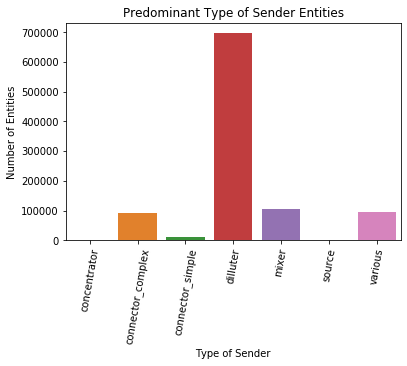

In [49]:
sns.barplot(data=aggr_parents, x='type', y='name')
plt.title('Predominant Type of Sender Entities')
plt.xlabel('Type of Sender')
plt.ylabel('Number of Entities')
plt.xticks(rotation=80)
plt.savefig('iter4a.pdf')

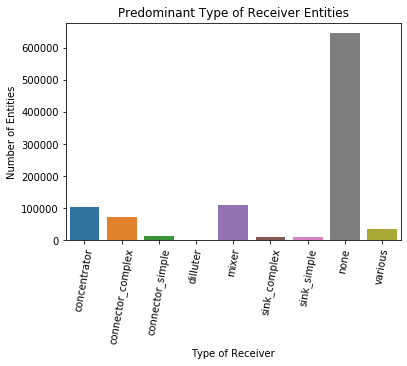

In [53]:
sns.barplot(data=aggr_children, x='type', y='name')
plt.title('Predominant Type of Receiver Entities')
plt.xlabel('Type of Receiver')
plt.ylabel('Number of Entities')
plt.xticks(rotation=80)
plt.savefig('iter4b.pdf')

In [2]:
sql('''
SELECT token, max(date)
FROM Price
GROUP BY token''')

,token,max(date)
0,0chain,1566691200
1,0x,1566691200
2,0xbtc,1566691200
3,0xcert,1566691200
4,1irstcoin,1566691200
5,1sg,1566691200
6,1world,1566691200
7,4new,1566691200
8,abcc-token,1566691200
9,abulaba,1566691200


In [54]:
d = sql('''
SELECT 
    1.0*blocknumber as blocknumber, timestamp as timestamp
FROM ETransfer
where blocknumber / 8640 * 8640 = blocknumber
GROUP BY blocknumber''')

,blocknumber,timestamp,date,timestamp_c
0,3067200.0,1470869782.0,2016-08-10 22:56:22,1470869782
1,3214080.0,1471669285.0,2016-08-20 05:01:25,1471669285
2,3248640.0,1471857761.0,2016-08-22 09:22:41,1471857761
3,3430080.0,1472853327.0,2016-09-02 21:55:27,1472853327
4,3473280.0,1473092357.0,2016-09-05 16:19:17,1473092357
5,3594240.0,1473772766.0,2016-09-13 13:19:26,1473772766
6,3646080.0,1474074285.0,2016-09-17 01:04:45,1474074285
7,3663360.0,1474174087.0,2016-09-18 04:48:07,1474174087
8,3672000.0,1474224550.0,2016-09-18 18:49:10,1474224550
9,3706560.0,1474427403.0,2016-09-21 03:10:03,1474427403


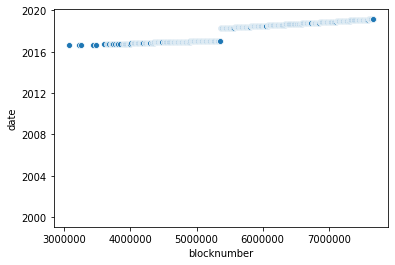

In [63]:
d['timestamp_c'] = d['timestamp'].str.replace('.0','', regex=False)
d['date'] = pd.to_datetime(d['timestamp_c'],unit='s')
sns.scatterplot(data=d, x='blocknumber', y='date')
d